In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import yfinance as yf
from datetime import datetime

In [3]:
pd.set_option('display.max_columns', None)

In [4]:
dfscrip = pd.read_csv('/content/drive/MyDrive/ColabData/USStockScrip.csv')
print('Total script count -' , len(dfscrip))
#dfscrip.sample(3)

df3 = pd.read_csv('/content/drive/MyDrive/ColabData/USStockClose.csv')
df3['Date'] = pd.to_datetime(df3['Date'])
print('Total record count -' , len(df3))
#df3.sample(3)
#df3.groupby('Date')['Close'].count()

Total script count - 5793
Total record count - 178720


In [5]:
df3['PClose'] = df3.groupby('Ticker')['Close'].shift(1)
df3['Return'] = (df3['Close'] - df3['PClose'])*100 / df3['PClose']
df3['CurrentClose'] = df3.groupby('Ticker')['Close'].transform('last')
df3['CurrentReturn'] = (df3['CurrentClose'] - df3['Close'])*100 / df3['Close']
df4 = pd.merge(df3, dfscrip[['Symbol','Security Name']], left_on='Ticker', right_on='Symbol', how='left')

#df[df['Close']>=3].sort_values(by=['Return'], ascending=True).head(10)
df4[(df4['Close']>=3) & (df4['CurrentReturn']>=10)].sort_values(by=['Return'], ascending=True).head(3)

,Date,Ticker,Close,PClose,Return,CurrentClose,CurrentReturn,Symbol,Security Name
118141,2023-09-01,OTLK,4.52,33.400002,-86.467067,7.40,63.716817,OTLK,"Outlook Therapeutics, Inc. - Common Stock"
19443,2024-07-01,BNED,6.12,43.000000,-85.767442,11.30,84.640529,BNED,"Barnes & Noble Education, Inc Common Stock"
123967,2023-07-03,PIRS,13.60,68.000000,-79.999999,17.08,25.588231,PIRS,"Pieris Pharmaceuticals, Inc. - Common Stock"


In [14]:
df5 = df4.sort_values(by=['Ticker', 'Date'])
df5['Return-6'] = df5.groupby('Ticker')['Close'].shift(6)
df5['Return-3'] = df5.groupby('Ticker')['Close'].shift(3)
df5['Return-2'] = df5.groupby('Ticker')['Close'].shift(2)
df5['Return-1'] = df5.groupby('Ticker')['Close'].shift(1).fillna(df5['Close'])
df5['Return+1'] = df5.groupby('Ticker')['Close'].shift(-1).fillna(df5['Close'])
df5['Return+3'] = df5.groupby('Ticker')['Close'].shift(-3).fillna(df5['Return+1'])
df5['Return+6'] = df5.groupby('Ticker')['Close'].shift(-6).fillna(df5['Return+3'])
df5['Return+12'] = df5.groupby('Ticker')['Close'].shift(-12).fillna(df5['Return+6'])
df5['Return-2'] = df5['Return-2'].fillna(df5['Return-1'])
df5['Return-3'] = df5['Return-3'].fillna(df5['Return-2'])
df5['Return-6'] = df5['Return-6'].fillna(df5['Return-3'])

#df5['Return-3'] = (df5['Close'] - df5['Return-3'])*100/df5['Close']
#df5['Return-2'] = (df5['Close'] - df5['Return-2'])*100/df5['Close']
#df5['Return-1'] = (df5['Close'] - df5['Return-1'])*100/df5['Close']
#df5['Return+1'] = (df5['Return+1'] - df5['Close'])*100/df5['Close']
#df5['Return+3'] = (df5['Return+3'] - df5['Close'])*100/df5['Close']
#df5['Return+6'] = (df5['Return+6'] - df5['Close'])*100/df5['Close']
#df5['Return+12'] = (df5['Return+12'] - df5['Close'])*100/df5['Close']

#df5[df5['Ticker']=='EPAM']

In [15]:
#data selection - select big crash stocks with some value
df6 = df5.dropna(subset=['Return'])
df7=df6.loc[df6.groupby('Ticker')['Return'].idxmin()]
df8=df7[(df7['Close']>= 2) & (df7['Return'] <= -25)].sort_values(by='Return')
print(df8.shape)
#df8.tail(3)

(1272, 17)


In [37]:
# train test split
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df8, test_size=0.2, random_state=42)
print(df_train.shape)
print(df_test.shape)

(1017, 16)
(255, 16)


In [17]:
df_train = df8[df8['Date'] < '2023-07-01']
df_test = df8[df8['Date'] >= '2023-07-01']
print(df_train.shape)
print(df_test.shape)

(878, 17)
(394, 17)


In [18]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
scaler = StandardScaler()

X_train_raw = pd.DataFrame(df_train, columns=['Close','Return-6','Return-3','Return-2','Return-1','Return'])
X_train = scaler.fit_transform(X_train_raw[['Close','Return-6', 'Return-3','Return-2','Return-1','Return']])
y_train = pd.DataFrame()
y_train['Target'] = df_train['Return+3']

X_test_raw = pd.DataFrame(df_test, columns=['Close','Return-6','Return-3','Return-2','Return-1','Return'])
X_test = scaler.transform(X_test_raw[['Close','Return-6', 'Return-3','Return-2','Return-1','Return']])
y_test = pd.DataFrame()
y_test['Target'] = df_test['Return+3']

In [19]:
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

model = RandomForestRegressor()
model.fit((X_train), np.array(y_train).ravel())
y_train_pred = model.predict((X_train))
y_test_pred = model.predict(X_test)
model_train_r2 = r2_score(y_train, y_train_pred)
model_test_r2 = r2_score(y_test, y_test_pred)
print('train score {0} test score {1}'.format(model_train_r2, model_test_r2))

train score 0.9661601916710544 test score 0.9128841489840996


In [34]:
#display
y_pred_df = pd.DataFrame(y_test_pred, columns=['Pred_Target'])
df_test_col = df_test[['Symbol','Return','Date','Return-6','Return-3','Return-2','Return-1', 'Close','Return+1','Return+3','Return+6','Return+12','CurrentClose','Security Name']]
df_test_col1 = df_test[['Close']]

y_test_verify = pd.concat([y_test.reset_index(), y_pred_df ], axis=1)
y_test_verify['diff'] = abs(y_test_verify['Target'] - y_test_verify['Pred_Target'])*100/y_test_verify['Target']
y_test_verify2 = pd.concat([y_test_verify , df_test_col1.reset_index() ], axis=1)
y_test_verify2['Pred Target Return%'] = (y_test_verify2['Pred_Target'] - y_test_verify2['Close'])*100/y_test_verify2['Close']
y_test_verify2['Act Target Return%'] = (y_test_verify2['Target'] - y_test_verify2['Close'])*100/y_test_verify2['Close']
y_test_verify2 = y_test_verify2.drop(columns=['Close'])
X_test_verify = pd.concat([y_test_verify2, df_test_col.reset_index() ], axis=1)

X_test_verify

#y_test_verify2['outcome'] = np.where(y_test_verify2['Pred Target Return%'] > 10, np.where(y_test_verify2['Act Target Return%'] > 10, 'Buy - Profit', 'Buy - Loss') , 'Ignore')
strategy_conditions = [
    (X_test_verify['Pred Target Return%'] <= 10),
    (X_test_verify['Pred Target Return%'] > 10) & (X_test_verify['Return-6'] > X_test_verify['Return-1']) ,
    (X_test_verify['Pred Target Return%'] > 10)
]
strategy_choices = ['Ignore','Risk Buy','Buy']
X_test_verify['strategy'] = np.select(strategy_conditions, strategy_choices, default='unknown')

outcome_conditions = [
    (X_test_verify['Pred Target Return%'] <= 10),
    (((X_test_verify['Return+1'] - X_test_verify['Close'])*100/X_test_verify['Close'])>10),
    (((X_test_verify['Return+3'] - X_test_verify['Close'])*100/X_test_verify['Close'])>10),
    (((X_test_verify['Return+6'] - X_test_verify['Close'])*100/X_test_verify['Close'])>10),
    (((X_test_verify['Return+12'] - X_test_verify['Close'])*100/X_test_verify['Close'])>10)   #(X_test_verify['Pred Target Return%'] > 10) &
]
outcome_choices = ['Ignore','Profit','Profit','Profit','Profit']
X_test_verify['outcome'] = np.select(outcome_conditions, outcome_choices, default='Loss')
print("Ignored Target as 0 for ",len(X_test_verify[X_test_verify['Target'] == 0]))
#X_test_verify[X_test_verify['Target'] != 0].sort_values('diff', ascending=False).head(3)
#X_test_verify[X_test_verify['Date'] == pd.to_datetime('2023-07-03')].sort_values('Pred Target Return%', ascending=False).head(10)
X_test_verify.sample(1)

Ignored Target as 0 for  0


,index,Target,Pred_Target,diff,index,Pred Target Return%,Act Target Return%,index,Symbol,Return,Date,Return-6,Return-3,Return-2,Return-1,Close,Return+1,Return+3,Return+6,Return+12,CurrentClose,Security Name,strategy,outcome
201,98816,12.3,12.9807,5.534144,98816,-3.345498,-8.413999,98816,LWAY,-35.370549,2024-06-03,14.89,12.32,18.9,20.780001,13.43,12.3,12.3,12.3,12.3,11.77,"Lifeway Foods, Inc. - Common Stock",Ignore,Ignore


In [61]:
X_test_verify[(X_test_verify['Date'] >= pd.to_datetime('2023-09-01')) & (X_test_verify['strategy'] != 'Ignore')].sort_values('Date', ascending=True).head(40)

,index,Target,Pred_Target,diff,index,Pred Target Return%,Act Target Return%,index,Symbol,Return,Date,Return-6,Return-3,Return-2,Return-1,Close,Return+1,Return+3,Return+6,Return+12,CurrentClose,Security Name,strategy,outcome
190,173682,7.550000,7.890600,4.511257,173682,10.823037,6.039330,173682,WPRT,-36.314851,2023-09-01,11.300000,6.900000,7.910000,11.180000,7.120000,5.920000,7.550000,6.220000,6.220000,5.890000,Westport Fuel Systems Inc - Common Shares,Risk Buy,Loss
180,18751,3.330000,5.196250,56.043549,18751,29.582288,-16.957613,18751,BLNK,-36.750787,2023-09-01,9.120000,6.750000,6.170000,6.340000,4.010000,3.040000,3.330000,3.230000,3.230000,3.060000,Blink Charging Co. - Common Stock,Risk Buy,Loss
174,153741,1.990000,2.761500,38.768843,153741,19.545457,-13.852811,153741,TCS,-37.057224,2023-09-01,4.430000,2.480000,3.300000,3.670000,2.310000,2.210000,1.990000,1.370000,1.370000,0.850000,Container Store (The) Common Stock,Risk Buy,Loss
168,132691,7.720000,12.590900,63.094565,132691,33.803404,-17.959618,132691,RDFN,-37.640823,2023-09-01,7.200000,10.060000,13.370000,15.090000,9.410000,6.980000,7.720000,7.000000,7.000000,7.430000,Redfin Corporation - Common Stock,Buy,Loss
215,46543,3.250000,3.780979,16.337801,46543,20.031061,3.174600,46543,EGHT,-34.511432,2023-09-01,5.190000,3.960000,4.400000,4.810000,3.150000,2.600000,3.250000,2.820000,2.820000,2.830000,8x8 Inc Common Stock,Risk Buy,Loss
219,89784,3.710000,3.912743,5.464764,89784,25.408427,18.910262,89784,JMIA,-34.315792,2023-09-01,3.170000,2.900000,3.760000,4.750000,3.120000,2.860000,3.710000,6.910000,6.910000,11.110000,Jumia Technologies AG American Depositary Shar...,Buy,Profit
121,6898,9.780000,11.723700,19.874236,6898,25.253209,4.487180,6898,AMSC,-41.971481,2023-09-01,5.360000,5.320000,6.340000,16.129999,9.360000,7.210000,9.780000,13.710000,13.710000,22.670000,American Superconductor Corporation - Common S...,Buy,Profit
115,127018,4.970000,5.033842,1.284547,127018,16.794474,15.313222,127018,PRPH,-42.379680,2023-09-01,7.390000,9.150000,7.240000,7.480000,4.310000,4.380000,4.970000,4.560000,4.560000,3.000000,"ProPhase Labs, Inc. - Common Stock",Buy,Profit
255,89226,2.200000,4.119100,87.231815,89226,21.149997,-35.294118,89226,JG,-31.999998,2023-09-01,13.400000,6.000000,5.400000,5.000000,3.400000,2.800000,2.200000,3.020000,3.020000,2.870000,Aurora Mobile Limited - American Depositary Sh...,Risk Buy,Loss
258,128785,6.220000,7.293100,17.252416,128785,11.345035,-5.038174,128785,PTON,-31.841827,2023-09-01,12.660000,7.730000,8.190000,9.610000,6.550000,5.390000,6.220000,4.600000,4.600000,3.320000,"Peloton Interactive, Inc. - Common Stock",Risk Buy,Loss


[*********************100%%**********************]  1 of 1 completed


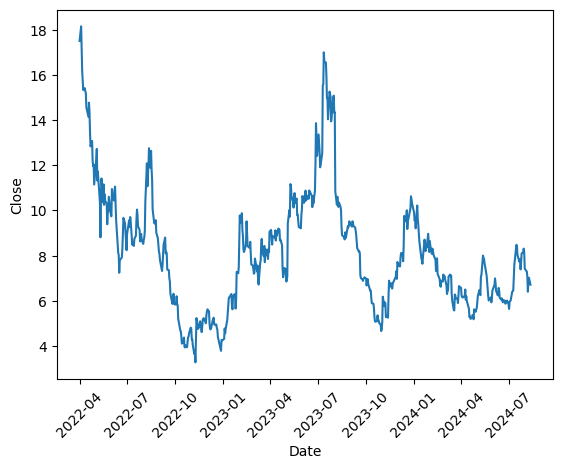

In [42]:
start_date = '2022-04-01'
end_date = datetime.now()
df_detail = yf.download("RDFN", start_date, end_date)
#df_detail.reset_index(inplace=True)
#df_detail['Date']=pd.to_datetime(df_detail['Date'])
sns.lineplot(df_detail, x='Date', y='Close')
plt.xticks(rotation=45)
plt.show()

In [40]:
X_test_verify[(X_test_verify['Date'] <= pd.to_datetime('2023-12-03')) & (X_test_verify['strategy'] != 'Ignore')].groupby(['Date','strategy','outcome'])['outcome'].count()

Date        strategy  outcome
2023-08-01  Buy       Profit      1
            Risk Buy  Loss        1
                      Profit      2
2023-09-01  Buy       Loss        2
                      Profit      5
            Risk Buy  Loss        9
                      Profit      1
2023-10-02  Buy       Loss        1
                      Profit      2
            Risk Buy  Profit      7
2023-11-01  Buy       Profit      2
            Risk Buy  Loss        3
                      Profit     12
2023-12-01  Buy       Loss        2
                      Profit      1
            Risk Buy  Loss        1
                      Profit      2
Name: outcome, dtype: int64

In [76]:
inv = 100/X_test_verify[(X_test_verify['strategy'] == 'Buy')].groupby(['Date'])['outcome'].count()
inv2= pd.merge(inv, X_test_verify[(X_test_verify['strategy'] == 'Buy')] , on='Date' , how='inner')
#_test_verify[(X_test_verify['strategy'] == 'Buy')][['Date']]
inv3 = inv2[['Date','outcome_x','Close','Symbol','Return+3','Return+6','Return+12']]
inv3['p/l+3'] = inv3['outcome_x']/inv3['Close']*inv3['Return+3']
inv3['p/l+6'] = inv3['outcome_x']/inv3['Close']*inv3['Return+6']
inv3['p/l+12'] = inv3['outcome_x']/inv3['Close']*inv3['Return+12']
inv3.groupby('Date')[['outcome_x','p/l+3','p/l+6','p/l+12']].agg(['sum','count'])
#inv3.loc[inv3['Date'] <= pd.to_datetime('2024-02-01')].agg({'outcome_x': ['sum', 'count'], 'p/l+3': 'sum', 'p/l+6': 'sum', 'p/l+12': 'sum'})

<ipython-input-76-b893ef370a75>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inv3['p/l+3'] = inv3['outcome_x']/inv3['Close']*inv3['Return+3']
<ipython-input-76-b893ef370a75>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inv3['p/l+6'] = inv3['outcome_x']/inv3['Close']*inv3['Return+6']
<ipython-input-76-b893ef370a75>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation

outcome_x             p/l+3             p/l+6            p/l+12  \
                 sum count         sum count         sum count         sum   
Date                                                                         
2023-08-01     100.0     1   89.853824     1  108.254514     1  124.677557   
2023-09-01     100.0     7   96.037609     7  119.384029     7  119.384029   
2023-10-02     100.0     3  197.877728     3  192.210494     3  192.210494   
2023-11-01     100.0     2  172.262632     2  166.223482     2  166.223482   
2023-12-01     100.0     3   86.468319     3   91.390934     3   91.390934   
2024-02-01     100.0     3   68.256075     3   83.401536     3   83.401536   
2024-03-01     100.0     3   79.610948     3   79.610948     3   79.610948   
2024-04-01     100.0     4   79.677541     4   79.677541     4   79.677541   
2024-05-01     100.0    11  103.417219    11  103.417219    11  103.417219   
2024-06-03     100.0     7   95.864735     7   95.864735     7   95.864735   
2024-07-01     100.0     2  102.960803     2  102.960803     2  102.960803   
2024-08-01     100.0     4  100.000000     4  100.000000     4  100.000000   

                  
           count  
Date              
2023-08-01     1  
2023-09-01     7  
2023-10-02     3  
2023-11-01     2  
2023-12-01     3  
2024-02-01     3  
2024-03-01     3  
2024-04-01     4  
2024-05-01    11  
2024-06-03     7  
2024-07-01     2  
2024-08-01     4

<Axes: xlabel='Date'>

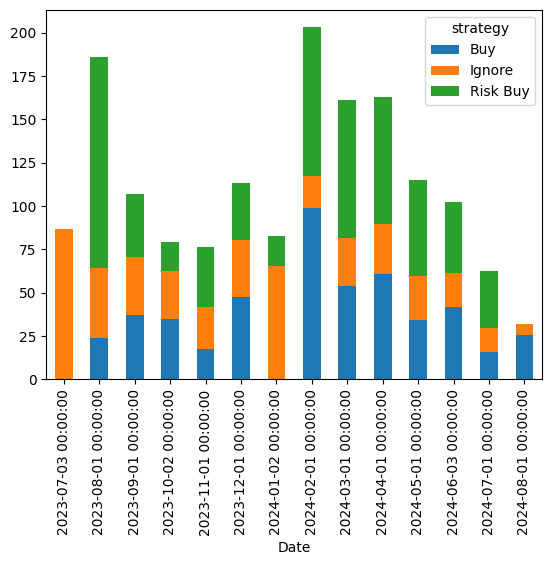

In [52]:
#sns.barplot(X_test_verify,  x='Date', y='diff', hue='strategy')
df_pivot = X_test_verify.pivot_table(index='Date', columns='strategy', values='diff', fill_value=0)
df_pivot.plot(kind='bar', stacked=True)
#df_pivot
    #X_test_verify[(X_test_verify['Date'] <= pd.to_datetime('2023-12-03')) & (X_test_verify['outcome'] != 'Ignore')].groupby(['Date','outcome'])['outcome'].count()

Showing chart for data items - 11


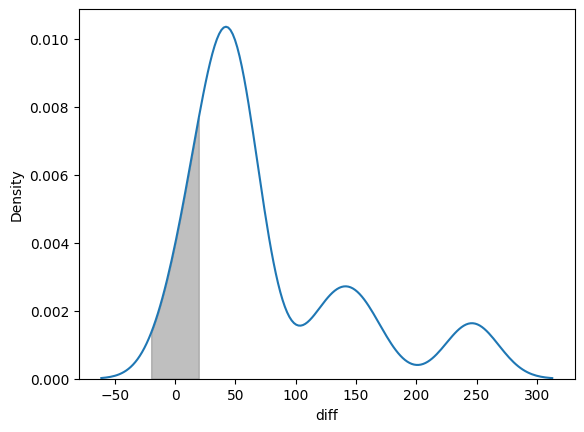

In [92]:
#df_plot= X_test_verify[X_test_verify['diff']<250]
df_plot= X_test_verify[(X_test_verify['diff']<250) & (X_test_verify['Date'] == pd.to_datetime('2023-07-03'))]
print('Showing chart for data items -', len(df_plot))
sns_plot = sns.kdeplot(df_plot['diff'] , bw_adjust=0.5)

x_values = sns_plot.lines[0].get_xdata()
y_values = sns_plot.lines[0].get_ydata()
plt.fill_between(x_values, 0, y_values, where=(x_values >= -20) & (x_values <= 20),
                 color='grey', alpha=0.5)